In [1]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import pyplot
from skimage import color
from skimage import io
import random

In [2]:
img = io.imread("gibbon.png")
img_gray = color.rgb2gray(img)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  


In [3]:
img_gray_90 = np.rot90(img_gray)
img_gray_180 = np.rot90(img_gray_90)
img_gray_270 = np.rot90(img_gray_180)

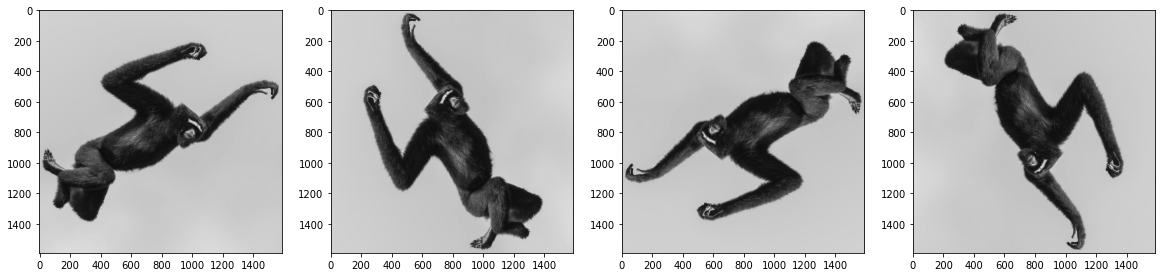

In [4]:
rotated_imgs = [img_gray, img_gray_90, img_gray_180, img_gray_270]
f,ax = plt.subplots(1,4, figsize=(20,20))

for i,image in enumerate(rotated_imgs):
  ax[i].imshow(image, cmap='gray')

plt.show()

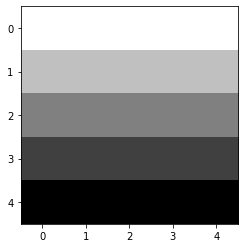

In [8]:
def standard_convolution(image, kernel):
  feature_map = np.zeros((image.shape[0] - kernel.shape[0] + 1,
                        image.shape[1] - kernel.shape[1] + 1))

  for r in range(image.shape[0] - kernel.shape[0]):
    for c in range(image.shape[1] - kernel.shape[1]):
      img_patch = image[r:r+kernel.shape[0], c:c+kernel.shape[1]]
      feature_map[r,c] = np.dot(img_patch.flatten(), kernel.flatten())

  return feature_map

edge_kernel = np.array([
  [1, 1, 1, 1, 1], 
  [0.5, 0.5, 0.5, 0.5, 0.5], 
  [0, 0, 0, 0, 0],
  [-0.5, -0.5, -0.5, -0.5, -0.5], 
  [-1, -1, -1, -1, -1],
])

plt.imshow(edge_kernel, cmap='gray')

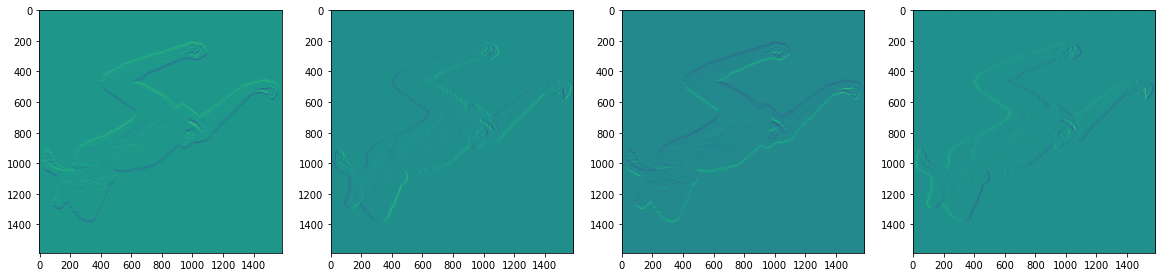

In [9]:
feature_maps = [standard_convolution(image, edge_kernel) for image in rotated_imgs]
aligned_feature_maps = [feature_maps[0]]

for i in range(1, len(feature_maps)):
  aligned_feature_maps.append(np.rot90(feature_maps[i],4-i))

f,ax = plt.subplots(1,4, figsize=(20,20))

for i,image in enumerate(aligned_feature_maps):
  ax[i].imshow(image)

plt.show()

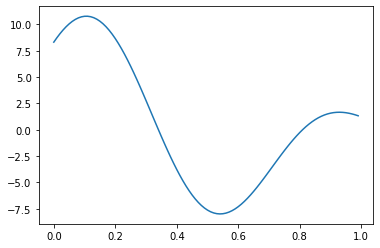

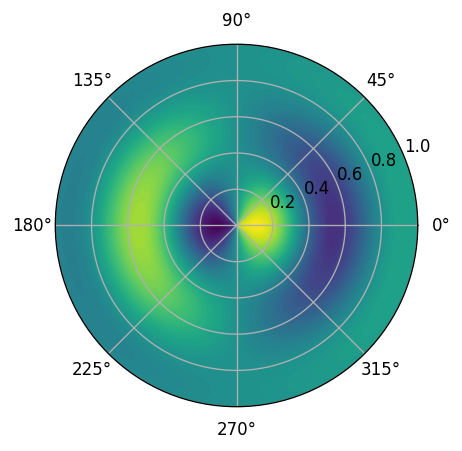

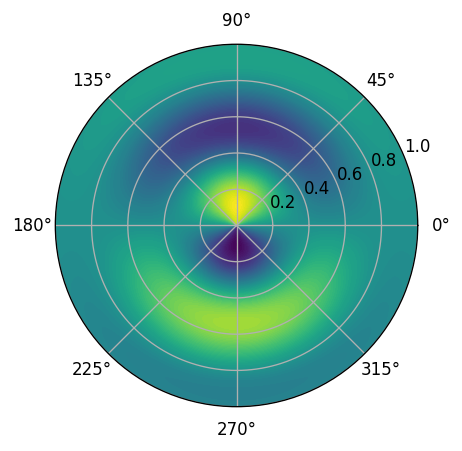

In [41]:
coefficient_list = [[random.uniform(-5,5), random.uniform(-5,5)] for x in range(3)]
X = np.arange(0,1,0.01) 
y = [0 for x in X]

for i,val in enumerate(X):
  for j,coeff in enumerate(coefficient_list):
    y[i] += coeff[0] * np.sin((j+1) * np.pi * val)
    y[i] += coeff[1] * np.cos((j+1) * np.pi * val)

plt.plot(X,y)

def R(r):
  total = 0

  for i,coeff in enumerate(coefficient_list):
    total += coeff[0] * np.sin((i+1) * np.pi * r)
    total += coeff[1] * np.cos((i+1) * np.pi * r)

  return total
  return np.e**(r**2)

def visualize_polar_filter(radial_profile, order):
  rlist=np.arange(0,1.01,0.01)
  thetalist = np.arange(0, 2*np.pi, np.pi/400)
  rmesh, thetamesh = np.meshgrid(rlist, thetalist)
  
  for f in [np.cos, np.sin]:
    full_function = f(order*thetamesh)*radial_profile(rmesh)
    
    fig,ax = plt.subplots(dpi=120,subplot_kw=dict(projection='polar'))
    ax.contourf(thetamesh,rmesh,full_function,100)
    plt.show()

visualize_polar_filter(R, 1)

In [33]:
def generate_polar_filters(n_rings, n_angles, radial_profile, order):
  polar_filter_real = np.zeros((n_angles, n_rings))
  polar_filter_complex = np.zeros((n_angles, n_rings))

  angles = np.arange(0, 2*np.pi, 2*np.pi/n_angles)
  rings = np.arange(0+1/n_rings, 1+1/n_rings, 1/n_rings)

  for i,theta in enumerate(angles):
    for j,r in enumerate(rings):
      polar_filter_real[i,j] = radial_profile(r) * np.cos(order * theta)
      polar_filter_complex[i,j] = radial_profile(r) * np.sin(order * theta)

  return polar_filter_real, polar_filter_complex

polar_real, polar_complex = generate_polar_filters(5, 12, lambda r: np.e**(r**2), 1)  
print(np.array_str(polar_real, precision=1, suppress_small=True))

[[ 1.   1.2  1.4  1.9  2.7]
 [ 0.9  1.   1.2  1.6  2.4]
 [ 0.5  0.6  0.7  0.9  1.4]
 [ 0.   0.   0.   0.   0. ]
 [-0.5 -0.6 -0.7 -0.9 -1.4]
 [-0.9 -1.  -1.2 -1.6 -2.4]
 [-1.  -1.2 -1.4 -1.9 -2.7]
 [-0.9 -1.  -1.2 -1.6 -2.4]
 [-0.5 -0.6 -0.7 -0.9 -1.4]
 [-0.  -0.  -0.  -0.  -0. ]
 [ 0.5  0.6  0.7  0.9  1.4]
 [ 0.9  1.   1.2  1.6  2.4]]


In [52]:
def generate_polar_filters(n_rings, n_angles, radial_profile, order):
  polar_filters = [np.zeros((n_angles, n_rings)) for i in range(2)]

  angles = np.arange(0, 2*np.pi, 2*np.pi/n_angles)
  rings = np.arange(0+1/n_rings, 1+1/n_rings, 1/n_rings)

  for i,theta in enumerate(angles):
    for j,r in enumerate(rings):
      for k,f in enumerate([np.cos, np.sin]):
        polar_filters[k][i,j] = radial_profile(r) * f(order * theta)

  return tuple(polar_filters)

polar_filter = generate_polar_filters(5, 12, lambda r: np.e**(r**2), 1)  
# print(np.array_str(polar_real, precision=1, suppress_small=True))

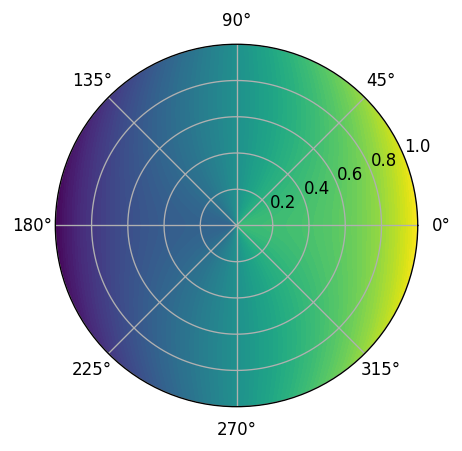

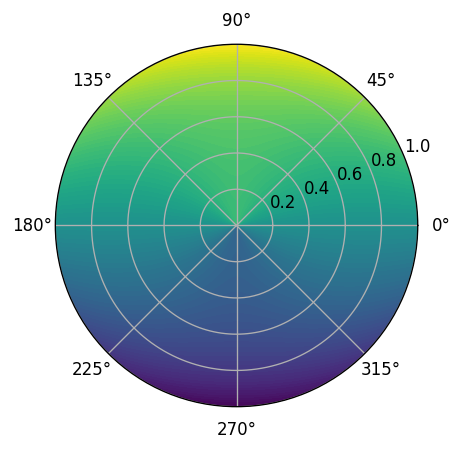

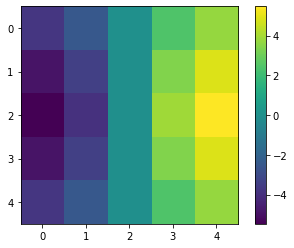

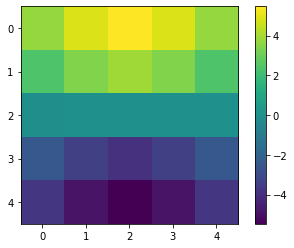

In [67]:
def generate_kernel(kernel_size, polar_filter, stdv):
  def polar_coord_distance(r1, theta1, r2, theta2):
    return (r1**2 + r2**2 - 2*r1*r2*np.cos(theta1-theta2))**0.5
    
  complex_kernel = [np.zeros((kernel_size, kernel_size)) for i in range(2)]

  angle_iter = 2*np.pi / polar_filter[0].shape[0] 
  radius_iter = 1 / polar_filter[0].shape[1]

  for row in range(kernel_size):
    for column in range(kernel_size):

      pixel_x = (column - int(kernel_size/2))/2
      pixel_y = (-1*row + int(kernel_size/2))/2

      pixel_radius = (pixel_x**2 + pixel_y**2)**0.5  
      pixel_angle = np.angle(complex(pixel_x, pixel_y))
        
      pixel_values = [0,0]

      for i,filter_part in enumerate(polar_filter):
        for angle,radii in enumerate(filter_part):
          polar_angle = angle*angle_iter
  
          for radius_index, polar_value in enumerate(radii):
            polar_radius = (radius_index + 1) * radius_iter
  
            distance = polar_coord_distance(pixel_radius, pixel_angle, polar_radius, polar_angle) 
            g_term = np.e**(-distance / (2*(stdv**2)))
  
            pixel_values[i] += g_term * polar_value

        complex_kernel[i][row,column] = pixel_values[i]

  return tuple(complex_kernel)

discretized_kernel = generate_kernel(5, polar_filter, 1.5)

visualize_polar_filter(lambda r: np.e**(r**2), 1)

for k in discretized_kernel:
  fig, ax = plt.subplots()
  shw = ax.imshow(k)
  bar = plt.colorbar(shw)
  plt.show()
  

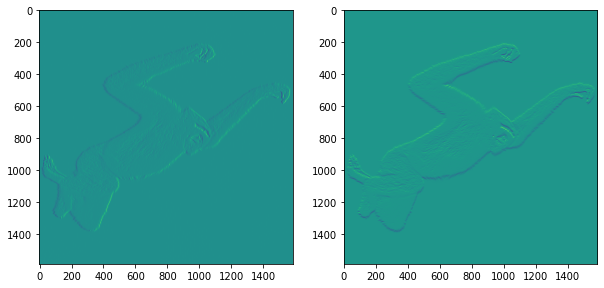

In [83]:
def generate_complex_feature_map(image, kernel):
  feature_map = [np.zeros((image.shape[0] - kernel[0].shape[0] + 1,
                           image.shape[1] - kernel[0].shape[1] + 1)) for x in range(2)]

  for r in range(image.shape[0] - kernel[0].shape[0]):
    for c in range(image.shape[1] - kernel[0].shape[1]):
      img_patch = image[r:r+kernel[0].shape[0], c:c+kernel[0].shape[1]]

      for i in range(2):
        feature_map[i][r,c] = np.dot(img_patch.flatten(), kernel[i].flatten())
  
  return tuple(feature_map)

complex_map = generate_complex_feature_map(img_gray, discretized_kernel)

f,ax = plt.subplots(1,2, figsize=(10,10))

for i,image in enumerate(complex_map):
  ax[i].imshow(image)

plt.show()

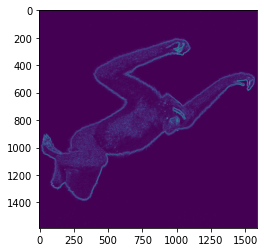

In [82]:
def generate_magnitude_map(complex_map):
  mag_map = np.zeros(complex_map[0].shape)
  
  for i in range(complex_map[0].shape[0]):
    for j in range(complex_map[0].shape[1]):
      magnitude = (complex_map[0][i,j]**2 + complex_map[1][i,j]**2)**0.5 
      # magnitude = np.angle(complex(real_map[i,j], complex_map[i,j])) 
      mag_map[i,j] = magnitude
  
  return mag_map

mag_map = generate_magnitude_map(complex_map)
plt.imshow(mag_map)

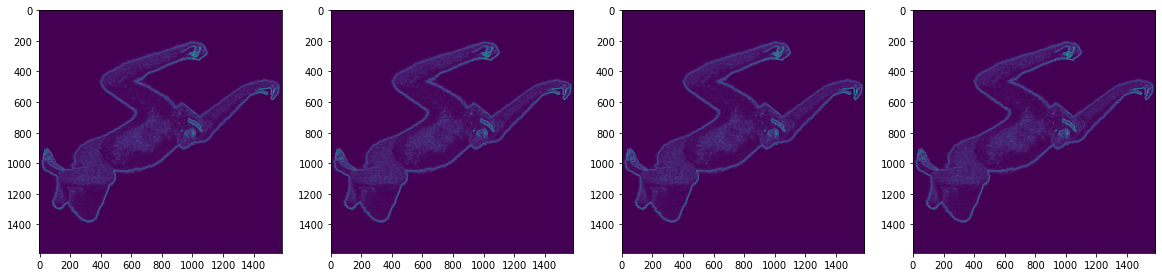

In [84]:
complex_maps = [generate_complex_feature_map(image, discretized_kernel) for image in rotated_imgs]
mag_maps = [generate_magnitude_map(c_map) for c_map in complex_maps]

aligned_mag_maps = [mag_maps[0]]

for i in range(1, len(mag_maps)):
  aligned_mag_maps.append(np.rot90(mag_maps[i],4-i))

f,ax = plt.subplots(1,4, figsize=(20,20))

for i,image in enumerate(aligned_mag_maps):
  ax[i].imshow(image)

plt.show()

In [ ]:
def generate_color_map(complex_map):
  mag_map = np.zeros(complex_map[0].shape)
  
  for i in range(complex_map[0].shape[0]):
    for j in range(complex_map[0].shape[1]):
      magnitude = (complex_map[0][i,j]**2 + complex_map[1][i,j]**2)**0.5 
      magnitude = np.angle(complex(real_map[i,j], complex_map[i,j])) 
      
       

      mag_map[i,j] = magnitude
  
  return mag_map

In [78]:
colo = np.zeros(complex_map[0].shape)

for i in range(complex_map[0].shape[0]):
  for j in range(complex_map[0].shape[1]):
    magnitude = (complex_map[0][i,j]**2 + complex_map[1][i,j]**2)**0.5 
    phase = np.angle(complex(complex_map[0][i,j], complex_map[1][i,j])) 
    new_map[i,j] = magnitude

plt.imshow(new_map)

AttributeError: ignored

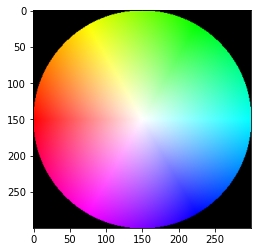

In [77]:
from PIL import Image
import colorsys
import math
 
 
im = Image.new("RGB", (300,300))
radius = min(im.size)/2.0
cx, cy = im.size[0]/2, im.size[1]/2
pix = im.load()

for x in range(im.width):
    for y in range(im.height):
        rx = x - cx
        ry = y - cy
        s = (rx ** 2.0 + ry ** 2.0) ** 0.5 / radius
        if s <= 1.0:
            h = ((math.atan2(ry, rx) / math.pi) + 1.0) / 2.0
            rgb = colorsys.hsv_to_rgb(h, s, 1.0)
            pix[x,y] = tuple([int(round(c*255.0)) for c in rgb])

plt.imshow(im)